In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

from one_particle import *
from qca import ChainQW

# Some checks

## A very simple model

Free theory

Adding interaction:

Generalized free solutions:

In [32]:
k = random.randint(0, L)*dk
c = np.random.rand(4) + 1j*np.random.rand(4)
psi_plus = c[0]*plane_wave(L=L, k=k) + c[1]*plane_wave(L=L, k=k-np.pi)
psi_minus = c[2]*plane_wave(L=L, k=-k) - c[2]*plane_wave(L=L, k=np.pi-k)
psi = normalize(np.block([psi_plus, psi_minus]))

In [33]:
qw = ChainQW(psi=psi, blocks_w=blocks_w, L=L, V=V, d=d)
for n in range(L):
    qw.evolve()
    assert np.allclose(np.exp(2j*(n+1)*k)*psi, qw.psi)

Interacting solutions:

In [36]:
k = random.randint(0, L)*dk
c = np.random.rand(4) + 1j*np.random.rand(4)
psi_plus = c[0]*plane_wave(L=L, k=k) + c[1]*plane_wave(L=L, k=k-np.pi)
x = np.arange(-L, L)
psi_minus = np.exp(-1j*chi*np.heaviside(x, 1, where=x%2==0))*(c[2]*np.exp(1j*k*x)+c[3]*np.exp(1j*(k-np.pi)*x))
psi = normalize(np.block([psi_plus, psi_minus]))

In [37]:
qw = ChainQW(psi=psi, blocks_w=blocks_w, L=L, V=V, d=d)
for n in range(L):
    qw.evolve()
    assert np.allclose(np.exp(2j*(n+1)*k)*psi, qw.psi)

In [14]:

# initial state of QCA
psi_minus = localized_particle(L=L, x0=L/2, k=-k)
#
psi_plus = np.zeros(2*L)
#psi_minus = localized_particle(L=L, x0=-L/2, k=k)

# quantum walk




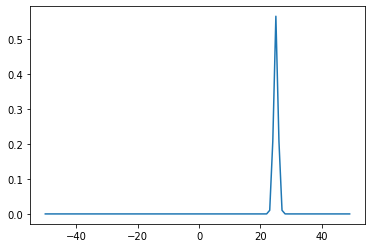

In [51]:
qw.plot_x()

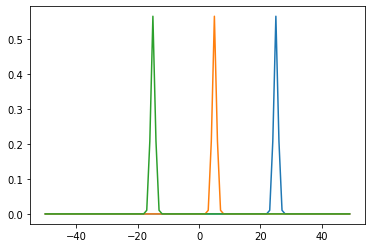

In [52]:
for _ in range(3):
    qw.plot_x()
    qw.evolve(10)

In [34]:
ps = []
for t in range(4*L):
    ps.append(qw.p_x(0))
    qw.evolve()

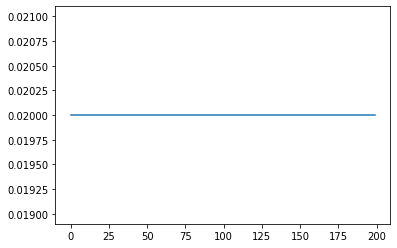

In [35]:
plt.plot(ps)